Our problem is to perform a quantum walk on a 1D path with 16 vertices. We first start with importing required libraries and initializing the number of qbits (size) and the number of nodes (nodes)

In [1]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences
size = 4
nodes = 2**size

Then we have to determine the probabilities of movement from a vertex. Excluding the first and the last vertex ( 0 and 15 ) the walk can go left or right to the adjacent nodes. For the nodes in the extremes there is only one direction to move in.
The code below first contains the functions to find out the probability of movment from one vertex to another on the path.

In [2]:
# Function for - state
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)
# function for diffuser oracle 
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

# function for 0 diffuser 
@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)
# defines probability for quantum walk
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*nodes  
    if i == 0:
        prob[1] = 1.0  
    elif i == nodes - 1:
        prob[i - 1] = 1.0  
    else:
        prob[i - 1] = 0.5  
        prob[i + 1] = 0.5   
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))
# function to apply probabilty on all nodes
@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(nodes):
        W_iteration(i,vertices,adjacent_vertices)

The code below contains the functions to perform the actual walk.

In [3]:
# checks if the vertices are adjacent or not
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1)| ((vertices - adjacent_vertices) == -1))

# performs a bitwise swap on 2 qarrays
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 
#applies bitwise swap on adjacent vertices
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))                        

The code below contains the main that performs the actual walk

In [4]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    
    allocate(size, vertices)  
    hadamard_transform(vertices)  
    allocate(size, adjacent_vertices)  
    
    W_operator(vertices, adjacent_vertices)  
    S_operator(vertices, adjacent_vertices)
    
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

Below is the circuit we get.

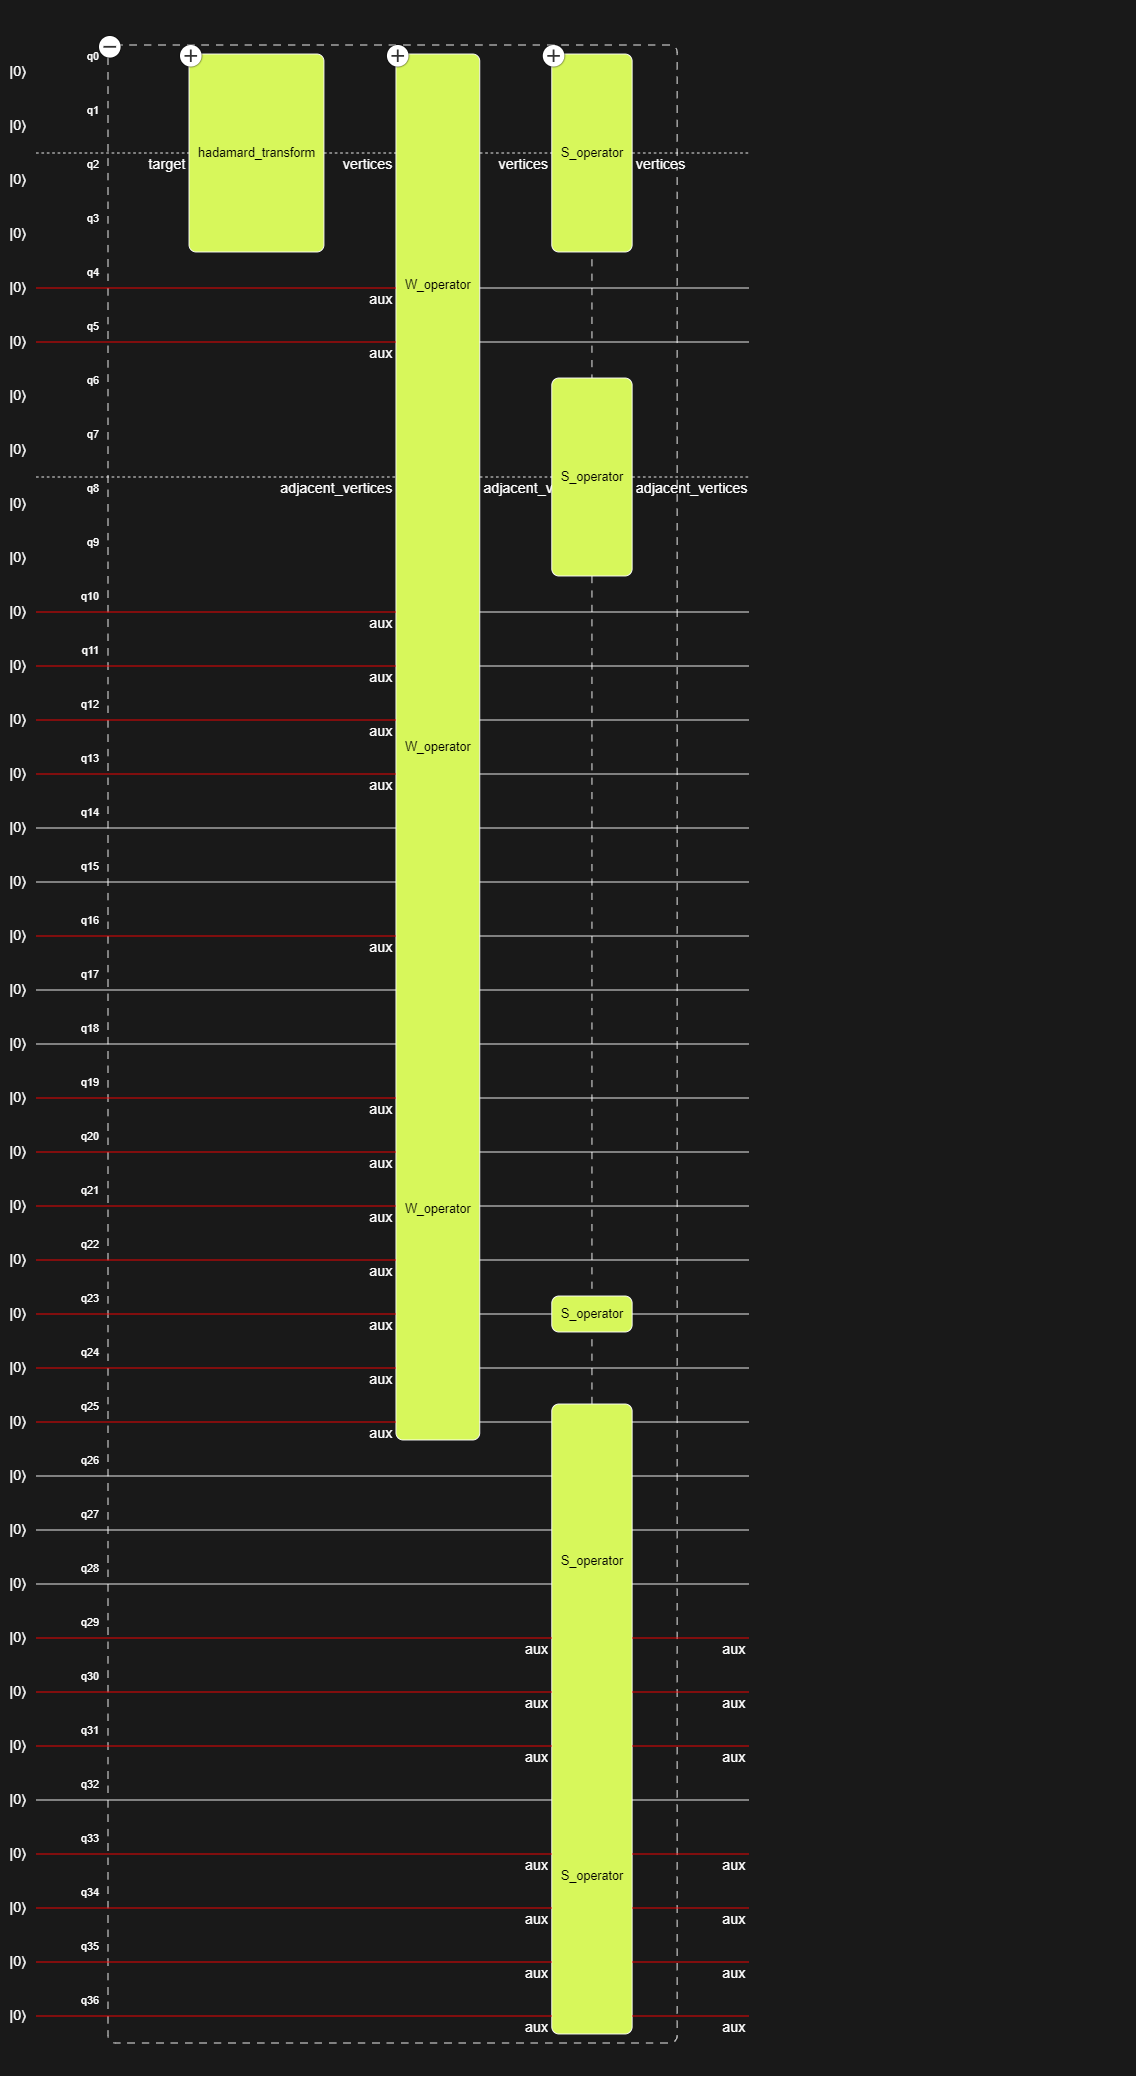